# Introduction

In [1]:
from pathlib import Path
import glob
import imghdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

Check the format of the images available:

In [2]:
images_folder = '../images'
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(images_folder + '/').rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

Load a random image from folders:

Shape of the image: (256, 256, 3)


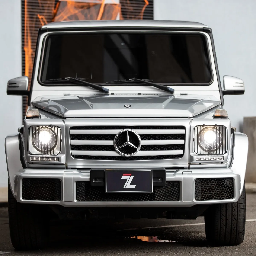

In [3]:
# test load image
image_files = glob.glob(images_folder + '/*/*.png')
image = np.random.choice(image_files)

pil_image = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
print(f'Shape of the image: {tf_image.shape}')
pil_image

## Utils

In [ ]:
def get_image_array(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    image = tf.keras.preprocessing.image.img_to_array(image)
    return image

## Preparing the images

All the images are located in folders that Tensorflow can read and then train the models. This flow of information (from images inside folders to data for training the model) could be handled in several ways, in our case we will create a *dataframe* which contains information about the image filename and the correct label for that image (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe).

In [ ]:
# define some global variables
batch_size = 32
target_size = (256, 256)

Get all the images in a complete dataframe that will be divided depending on the model objective:

In [5]:
# gather all images for training
all_imagefiles = pd.DataFrame(
    [[i, i.split('/')[-2]] for i in glob.glob("../images/*/*.png")],
    columns=['x_col', 'y_col']
)

In [131]:
# split images for correct and incorrect 
ic_df_images = all_imagefiles[(all_imagefiles['y_col'] == 'correct') | (all_imagefiles['y_col'] == 'incorrect')]
ic_train, ic_test = train_test_split(ic_df_images, test_size=0.2, random_state=42)
# get validation data
ic_train, ic_val = train_test_split(ic_train, test_size=0.2, random_state=42)

# split images for back and front
bf_df_images = all_imagefiles[(all_imagefiles['y_col'] == 'back') | (all_imagefiles['y_col'] == 'front')]
bf_train, bf_test = train_test_split(bf_df_images, test_size=0.2, random_state=42)
# get validation data
bf_train, bf_val = train_test_split(bf_train, test_size=0.2, random_state=42)

We have two `ImageDataGenerator` instances, one for training images and another one for validation and test images. Training images will be augmented through several methods in order o get more artificiall data (images) from the same base.

In [128]:
# image generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

Image datasets for Incorrect vs Correct:

In [129]:
ic_classes = ['incorrect', 'correct']

# train images datasets fot ic
ic_train_images = train_datagen.flow_from_dataframe(
  dataframe=ic_train,
  classes=ic_classes,
  x_col='x_col',
  y_col='y_col',
  target_size=target_size,
  class_mode='binary',
  batch_size=batch_size,
  shuffle=True
)
ic_validation_images = validation_datagen.flow_from_dataframe(
  dataframe=ic_val,
  classes=ic_classes,
  x_col='x_col',
  y_col='y_col',
  target_size=target_size,
  class_mode='binary',
  batch_size=batch_size,
  shuffle=False  
)
ic_test_images = validation_datagen.flow_from_dataframe(
  dataframe=ic_test,
  classes=ic_classes,
  x_col='x_col',
  y_col='y_col',
  target_size=target_size,
  class_mode='binary',
  batch_size=batch_size,
  shuffle=False  
)

ic_labels = list(ic_train_images.class_indices.keys())

Found 3541 validated image filenames belonging to 2 classes.
Found 886 validated image filenames belonging to 2 classes.
Found 1107 validated image filenames belonging to 2 classes.


Image datasets for Back vs Front

In [133]:
bf_classes = ['back', 'front']

# train images datasets fot bf
bf_train_images = train_datagen.flow_from_dataframe(
  dataframe=bf_train,
  classes=bf_classes,
  x_col='x_col',
  y_col='y_col',
  target_size=target_size,
  class_mode='binary',
  batch_size=batch_size,
  shuffle=True
)
bf_validation_images = validation_datagen.flow_from_dataframe(
  dataframe=bf_val,
  classes=bf_classes,
  x_col='x_col',
  y_col='y_col',
  target_size=target_size,
  class_mode='binary',
  batch_size=batch_size,
  shuffle=False  
)
bf_test_images = validation_datagen.flow_from_dataframe(
  dataframe=bf_test,
  classes=bf_classes,
  x_col='x_col',
  y_col='y_col',
  target_size=target_size,
  class_mode='binary',
  batch_size=batch_size,
  shuffle=False  
)

bf_labels = list(bf_train_images.class_indices.keys())

Found 2570 validated image filenames belonging to 2 classes.
Found 643 validated image filenames belonging to 2 classes.
Found 804 validated image filenames belonging to 2 classes.


## Callbacks

In [9]:
# callbacks
class AccReached(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, mode='min', verbose=1)

In [134]:
ic_check_point_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='models/checkpoints/ic_model.{val_loss:.2f}.h5',
  monitor='val_loss',
  mode='min',
  save_best_only=True,
)
bf_check_point_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='models/checkpoints/bf_model.{val_loss:.2f}.h5',
  monitor='val_loss',
  mode='min',
  save_best_only=True,
)

In [12]:
# learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001,
  decay_steps=10000,
  decay_rate=0.9
  )

# Model 1: Incorrect vs Correct

In [13]:
ic_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1014, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-15 09:51:18.762858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 09:51:18.762983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
ic_model.compile(
  loss='binary_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
  metrics=['accuracy'],
)

In [152]:
ic_history = ic_model.fit(
  ic_train_images,
  steps_per_epoch=ic_train_images.n // batch_size,
  epochs=55,
  verbose=1,
  callbacks=[AccReached(), early_stop, ic_check_point_callback],
  validation_data=ic_validation_images,
)

Epoch 1/55


2022-11-15 11:37:01.765462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 41s 342ms/step - loss: 0.3790 - accuracy: 0.8282 - val_loss: 0.3376 - val_accuracy: 0.8623
Epoch 2/55
110/110 [==============================] - 37s 328ms/step - loss: 0.3653 - accuracy: 0.8427 - val_loss: 0.3861 - val_accuracy: 0.8296
Epoch 3/55
110/110 [==============================] - 37s 330ms/step - loss: 0.3575 - accuracy: 0.8458 - val_loss: 0.3240 - val_accuracy: 0.8747
Epoch 4/55
110/110 [==============================] - 37s 332ms/step - loss: 0.3634 - accuracy: 0.8424 - val_loss: 0.3123 - val_accuracy: 0.8770
Epoch 5/55
110/110 [==============================] - 37s 333ms/step - loss: 0.3481 - accuracy: 0.8512 - val_loss: 0.3054 - val_accuracy: 0.8815
Epoch 6/55
110/110 [==============================] - 36s 328ms/step - loss: 0.3422 - accuracy: 0.8552 - val_loss: 0.2976 - val_accuracy: 0.8826
Epoch 7/55
110/110 [==============================] - 37s 332ms/step - loss: 0.3306 - accuracy: 0.8578 - val_loss: 0.2911 - val_accuracy: 0.8

### Load existing model

In [16]:
# load existing model
ic_model = tf.keras.models.load_model('models/checkpoints/ic_model.0.35.h5')

## Evaluation

In [154]:
ic_validations_labels = np.array(ic_validation_images.classes)
ic_predictions = ic_model.predict(ic_validation_images).reshape(-1)

28/28 [==============================] - 3s 113ms/step


In [155]:
print(ic_train_images.class_indices)

{'incorrect': 0, 'correct': 1}


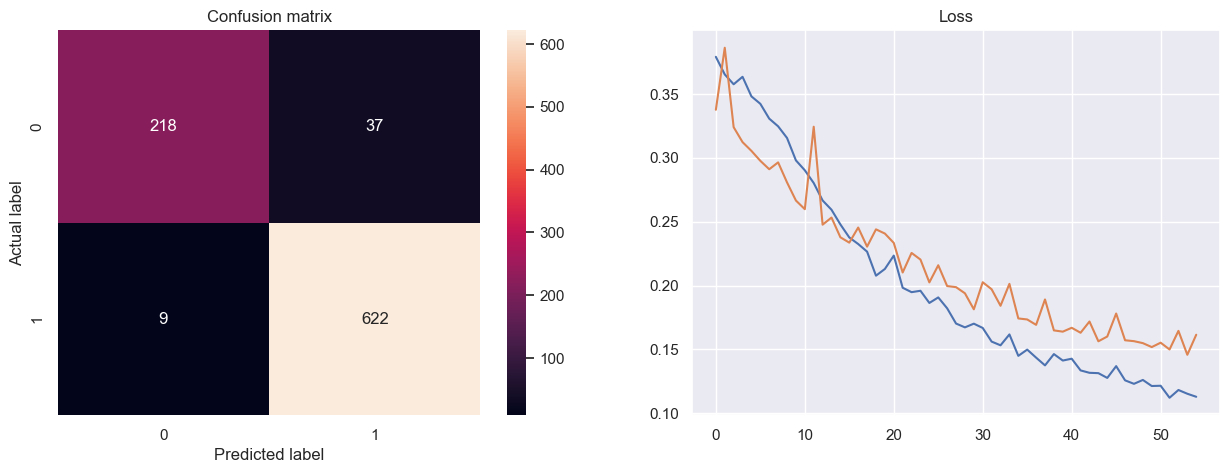

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# confusion matrix
ic_cm_old = confusion_matrix(ic_validations_labels, ic_predictions > 0.5)

sns.heatmap(ic_cm_old, annot=True, fmt="d", ax=ax[0])
ax[0].set_ylabel('Actual label')
ax[0].set_xlabel('Predicted label')
ax[0].set_title("Confusion matrix")

# losses
sns.lineplot(np.array(ic_history.history['loss']), ax=ax[1])
sns.lineplot(np.array(ic_history.history['val_loss']), ax=ax[1])
ax[1].set_title("Loss")

plt.show()

#### Evaluate errors

Seeking better precision:

In [157]:
ic_preds_1 = ic_predictions > 0.5
ic_prediction_1 = ic_predictions[ic_preds_1]  # get the probs predictions from model
ic_pred_label = np.where(ic_prediction_1 > 0.5, 1, 0)  # get the labels from probs
ic_true_1 = ic_validations_labels[ic_preds_1]  # get the true values for predictions
ic_errors_1 = np.where(ic_pred_label != ic_true_1, True, False) # get the errors
ic_errors_1_images = np.array(ic_validation_images.filenames)[ic_preds_1][ic_errors_1]  # get the images that are errors

(37, 1)
(622, 1)


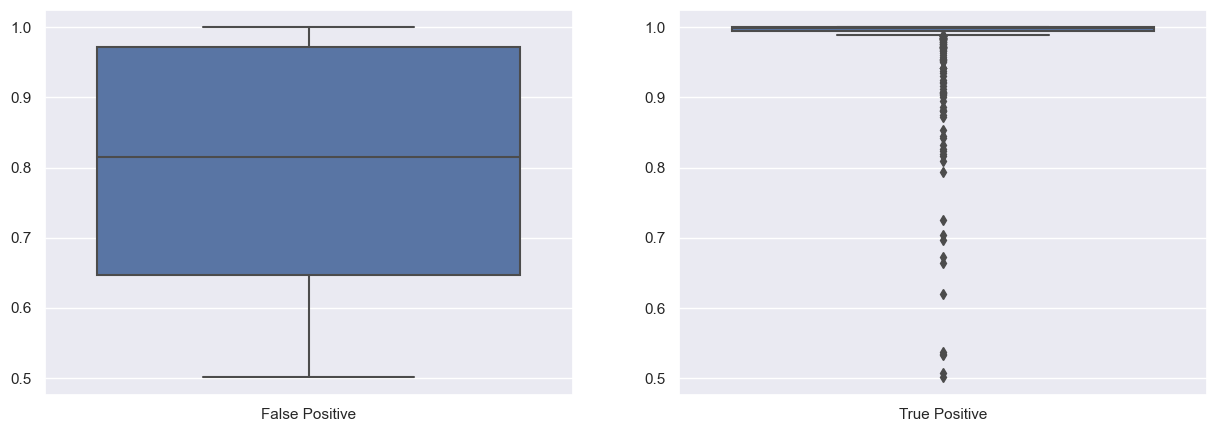

In [158]:
error_df = pd.DataFrame(ic_prediction_1[ic_errors_1], columns=['False Positive'])
correct_df = pd.DataFrame(ic_prediction_1[~ic_errors_1], columns=['True Positive'])
print(error_df.shape)
print(correct_df.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=error_df, orient='v', ax=ax[0])
sns.boxplot(data=correct_df, orient='v', ax=ax[1])
plt.show()

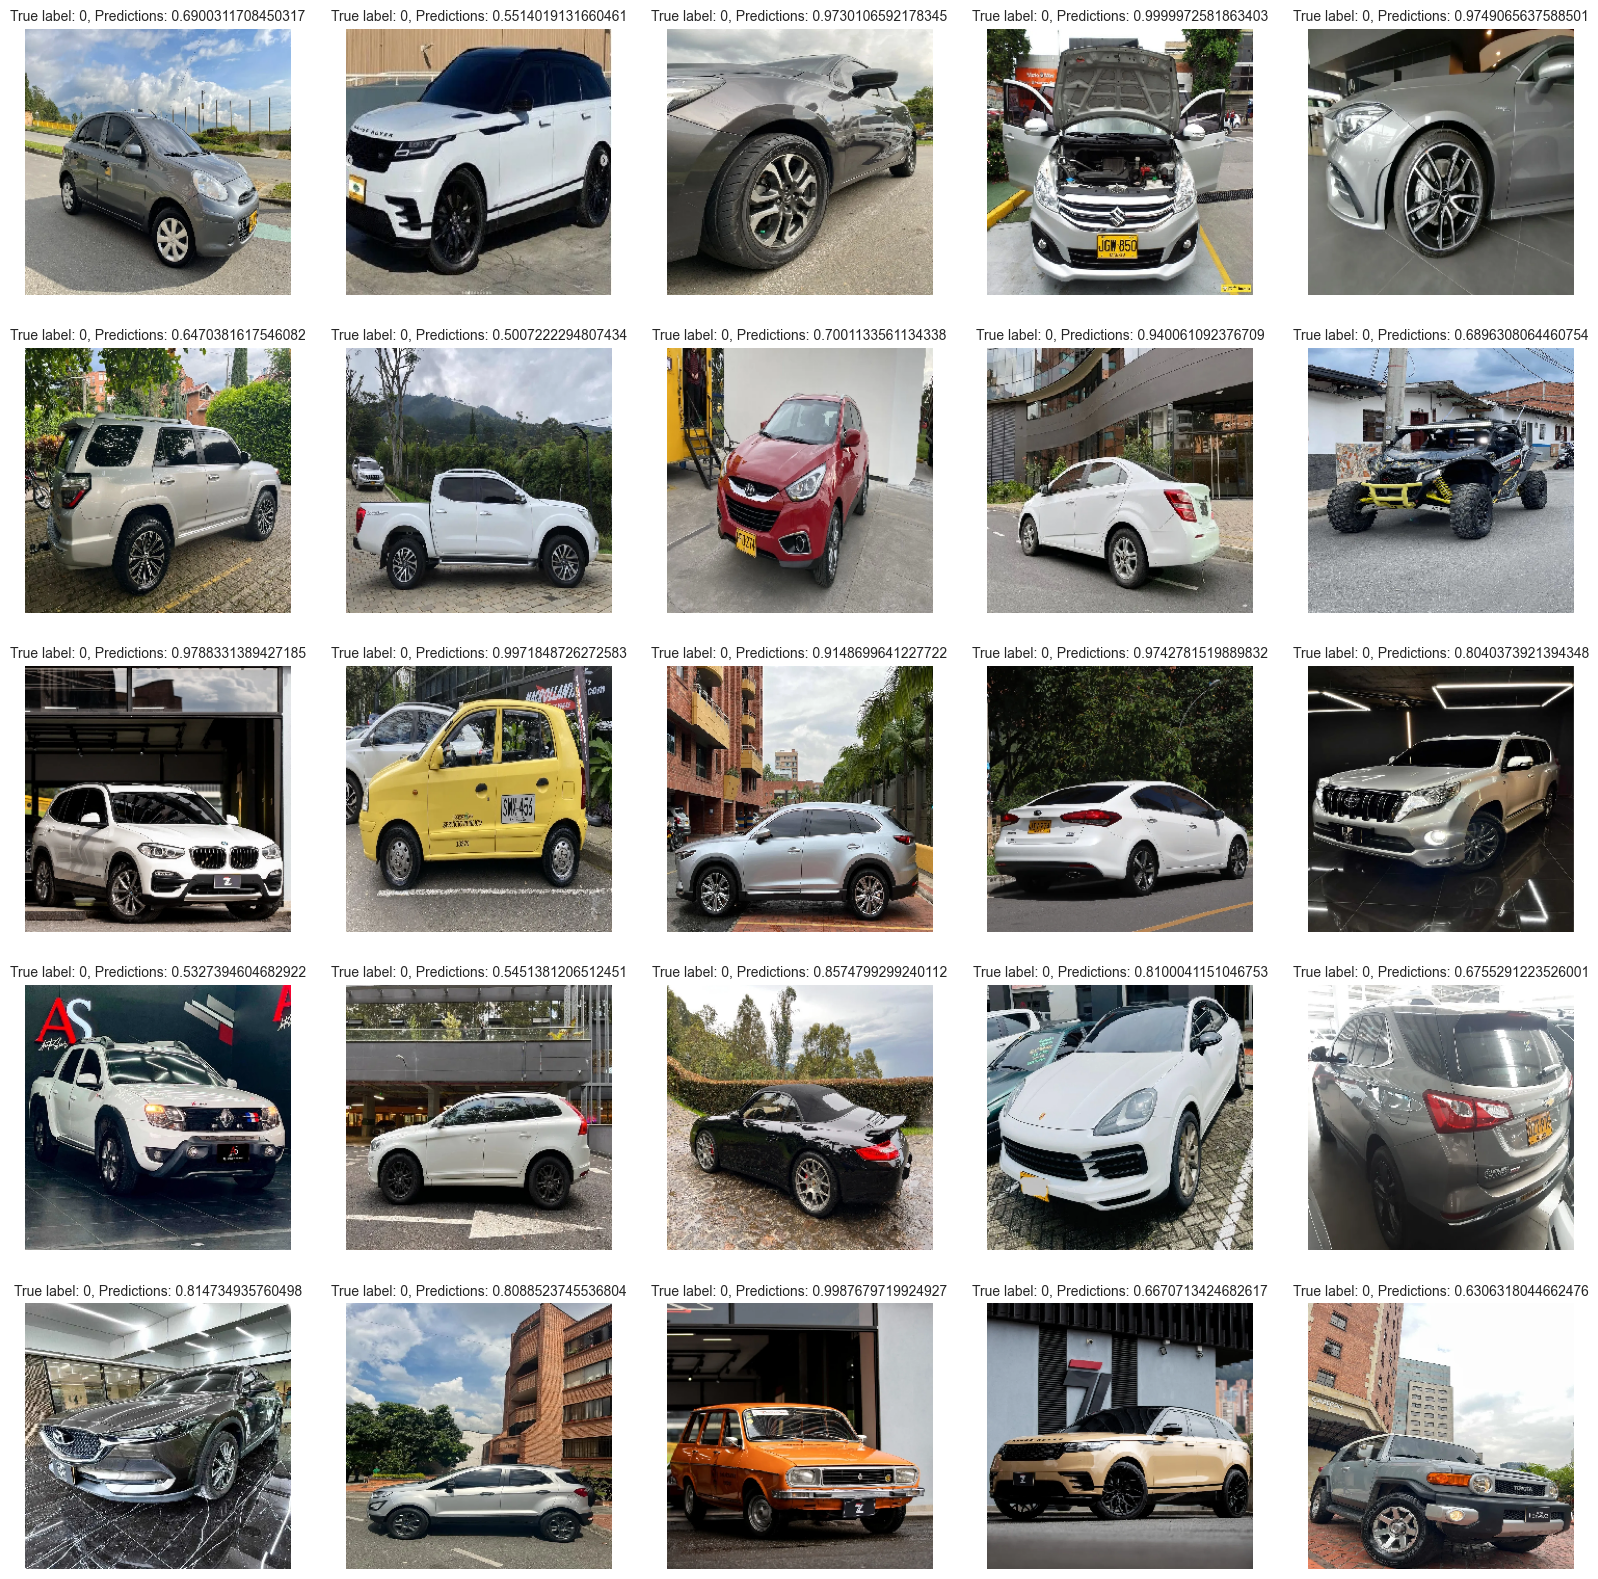

In [159]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i, ax in enumerate(fig.axes):
  try:
    error_image = tf.keras.preprocessing.image.load_img(ic_errors_1_images[i])
    ax.imshow(error_image)
    ax.axis('off')
    ax.set_title(f'True label: {ic_true_1[ic_errors_1][i]}, Predictions: {ic_prediction_1[ic_errors_1][i]}', fontsize=10)
  except IndexError:
    continue
plt.show()

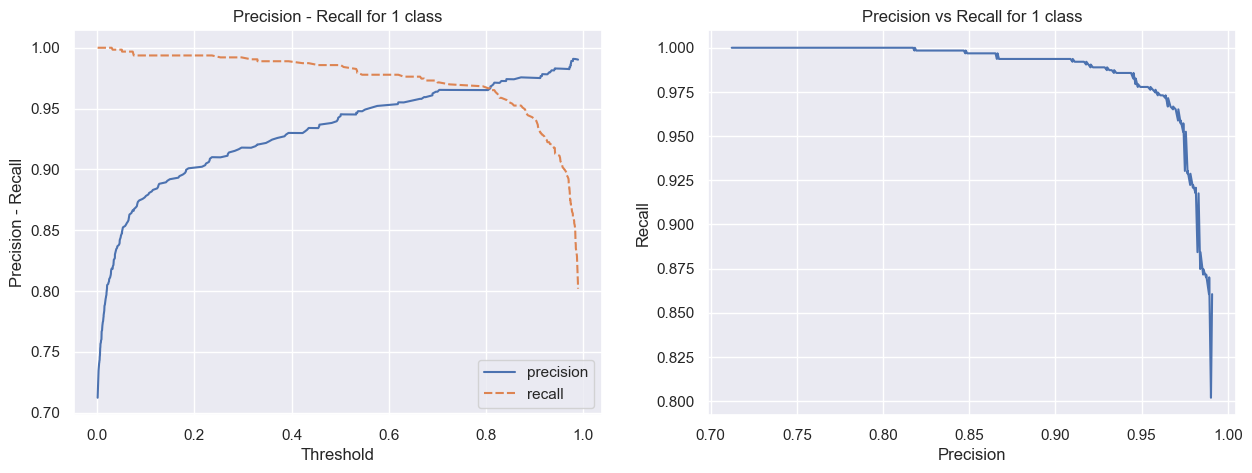

In [199]:
precision, recall, thresholds = precision_recall_curve(ic_validations_labels, ic_predictions)
prt = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1]}, index=thresholds)
prt = prt[(prt.index <= 0.99)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(data=prt, ax=ax[0])
ax[0].set_ylabel('Precision - Recall')
ax[0].set_xlabel('Threshold')
ax[0].set_title(f'Precision - Recall for 1 class')

sns.lineplot(x='precision', y='recall', data=prt, ax=ax[1])
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Precision')
ax[1].set_title(f'Precision vs Recall for 1 class')
plt.show()

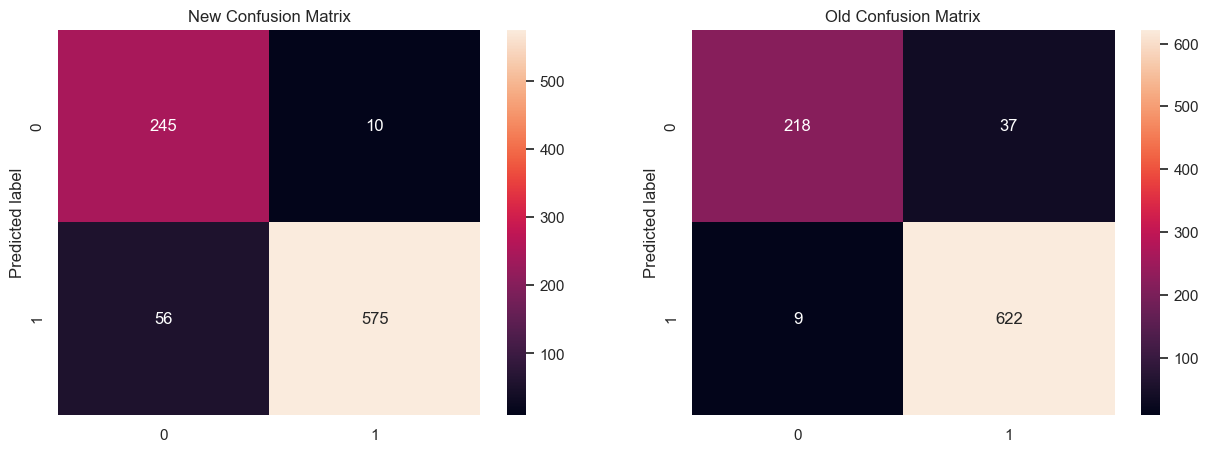

In [203]:
new_label_predictions = np.zeros(ic_predictions.shape)
thresholld = 0.95
for idx, row in enumerate(ic_predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

ic_new_cm = confusion_matrix(ic_validations_labels, new_label_predictions)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(ic_new_cm, annot=True, fmt="d", ax=ax[0])
ax[0].set_title('New Confusion Matrix')
ax[0].set_ylabel('Actual label')
ax[0].set_ylabel('Predicted label')

sns.heatmap(ic_cm_old, annot=True, fmt="d", ax=ax[1])
ax[1].set_title('Old Confusion Matrix')
ax[1].set_ylabel('Actual label')
ax[1].set_ylabel('Predicted label')

plt.show()

### Test Set

In [163]:
ic_test_predictions = ic_model.predict(ic_test_images)
ic_test_labels = np.array(ic_test_images.classes)

35/35 [==============================] - 4s 124ms/step


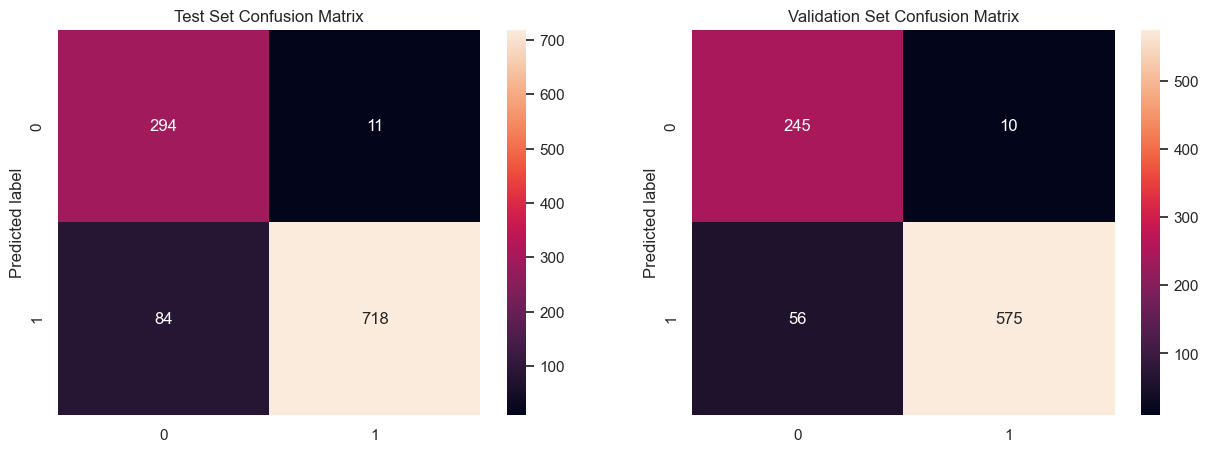

In [204]:
new_label_predictions = np.zeros(ic_test_predictions.shape)
thresholld = 0.95
for idx, row in enumerate(ic_test_predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

ic_test_cm = confusion_matrix(ic_test_labels, new_label_predictions)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(ic_test_cm, annot=True, fmt="d", ax=ax[0])
ax[0].set_title('Test Set Confusion Matrix')
ax[0].set_ylabel('Actual label')
ax[0].set_ylabel('Predicted label')

sns.heatmap(ic_new_cm, annot=True, fmt="d", ax=ax[1])
ax[1].set_title('Validation Set Confusion Matrix')
ax[1].set_ylabel('Actual label')
ax[1].set_ylabel('Predicted label')

plt.show()

In [165]:
ic_model.evaluate(ic_test_images)

35/35 [==============================] - 4s 103ms/step - loss: 0.1475 - accuracy: 0.9467


[0.14753787219524384, 0.9467028379440308]

# Model 2: Back vs Front

In [135]:
bf_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1014, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [136]:
bf_model.compile(
  loss='binary_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
  metrics=['accuracy'],
)

In [153]:
bf_history = bf_model.fit(
  bf_train_images,
  steps_per_epoch=bf_train_images.n // batch_size,
  epochs=55,
  verbose=1,
  callbacks=[AccReached(), early_stop, bf_check_point_callback],
  validation_data=bf_validation_images,
)

Epoch 1/55


2022-11-15 12:10:15.906846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 28s 340ms/step - loss: 0.5548 - accuracy: 0.7285 - val_loss: 0.4986 - val_accuracy: 0.7869
Epoch 2/55
80/80 [==============================] - 27s 337ms/step - loss: 0.5464 - accuracy: 0.7329 - val_loss: 0.4896 - val_accuracy: 0.7838
Epoch 3/55
80/80 [==============================] - 27s 335ms/step - loss: 0.5340 - accuracy: 0.7526 - val_loss: 0.4818 - val_accuracy: 0.7932
Epoch 4/55
80/80 [==============================] - 26s 326ms/step - loss: 0.5209 - accuracy: 0.7581 - val_loss: 0.5202 - val_accuracy: 0.7294
Epoch 5/55
80/80 [==============================] - 27s 335ms/step - loss: 0.5022 - accuracy: 0.7644 - val_loss: 0.4425 - val_accuracy: 0.8134
Epoch 6/55
80/80 [==============================] - 27s 327ms/step - loss: 0.4955 - accuracy: 0.7656 - val_loss: 0.4546 - val_accuracy: 0.7838
Epoch 7/55
80/80 [==============================] - 27s 338ms/step - loss: 0.4835 - accuracy: 0.7805 - val_loss: 0.4160 - val_accuracy: 0.8196
Epoch 8/55

### Load existing model

In [139]:
# load existing model
bf_model = tf.keras.models.load_model('models/checkpoints/bf_model.0.52.h5')

## Evaluation

In [166]:
bf_validations_labels = np.array(bf_validation_images.classes)
bf_predictions = bf_model.predict(bf_validation_images).reshape(-1)

21/21 [==============================] - 3s 125ms/step


In [167]:
print(bf_train_images.class_indices)

{'back': 0, 'front': 1}


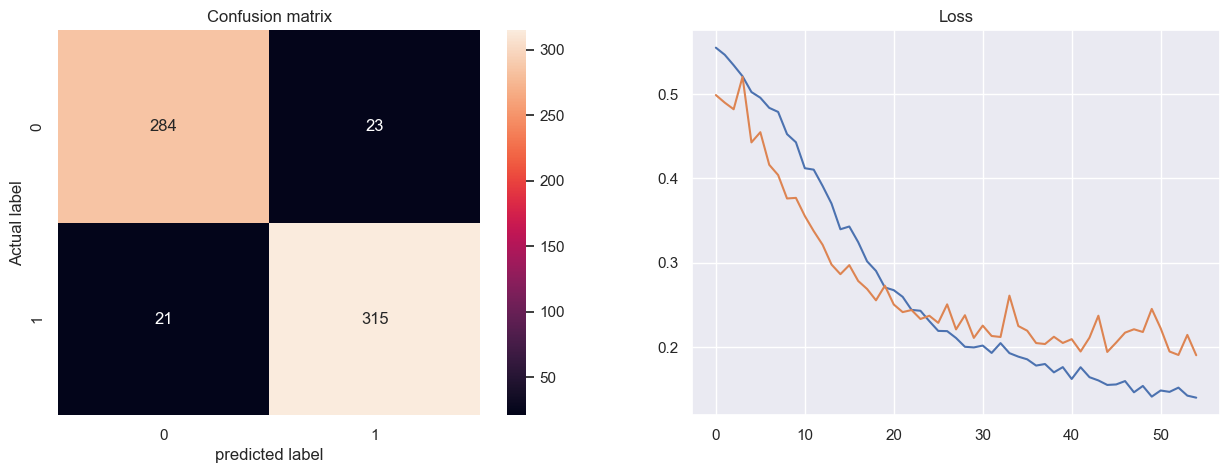

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# confusion matrix
bf_cm_old = confusion_matrix(bf_validations_labels, bf_predictions > 0.5)

sns.heatmap(bf_cm_old, annot=True, fmt="d", ax=ax[0])
ax[0].set_ylabel('Actual label')
ax[0].set_xlabel('predicted label')
ax[0].set_title("Confusion matrix")

# losses
sns.lineplot(np.array(bf_history.history['loss']), ax=ax[1])
sns.lineplot(np.array(bf_history.history['val_loss']), ax=ax[1])
ax[1].set_title("Loss")

plt.show()

### Evaluate errors

Seeking better precision:

In [169]:
bf_preds_1 = bf_predictions > 0.5
bf_prediction_1 = bf_predictions[bf_preds_1]  # get the probs predictions from model
bf_pred_label = np.where(bf_prediction_1 > 0.5, 1, 0)  # get the labels from probs
bf_true_1 = bf_validations_labels[bf_preds_1]  # get the true values for predictions
bf_errors_1 = np.where(bf_pred_label != bf_true_1, True, False) # get the errors
bf_errors_1_images = np.array(bf_validation_images.filenames)[bf_preds_1][bf_errors_1]  # get the images that are errors

(23, 1)
(315, 1)


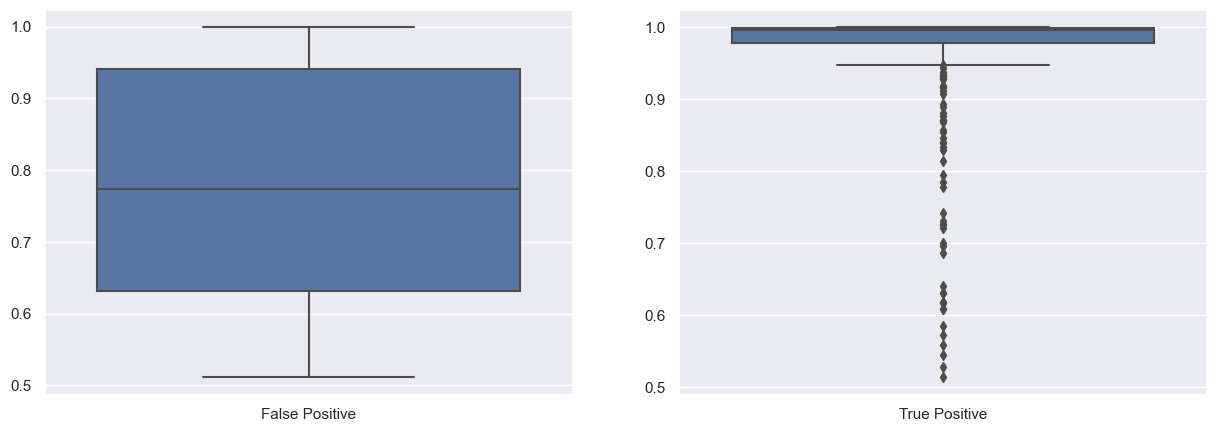

In [170]:
error_df = pd.DataFrame(bf_prediction_1[bf_errors_1], columns=['False Positive'])
correct_df = pd.DataFrame(bf_prediction_1[~bf_errors_1], columns=['True Positive'])
print(error_df.shape)
print(correct_df.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=error_df, orient='v', ax=ax[0])
sns.boxplot(data=correct_df, orient='v', ax=ax[1])
plt.show()

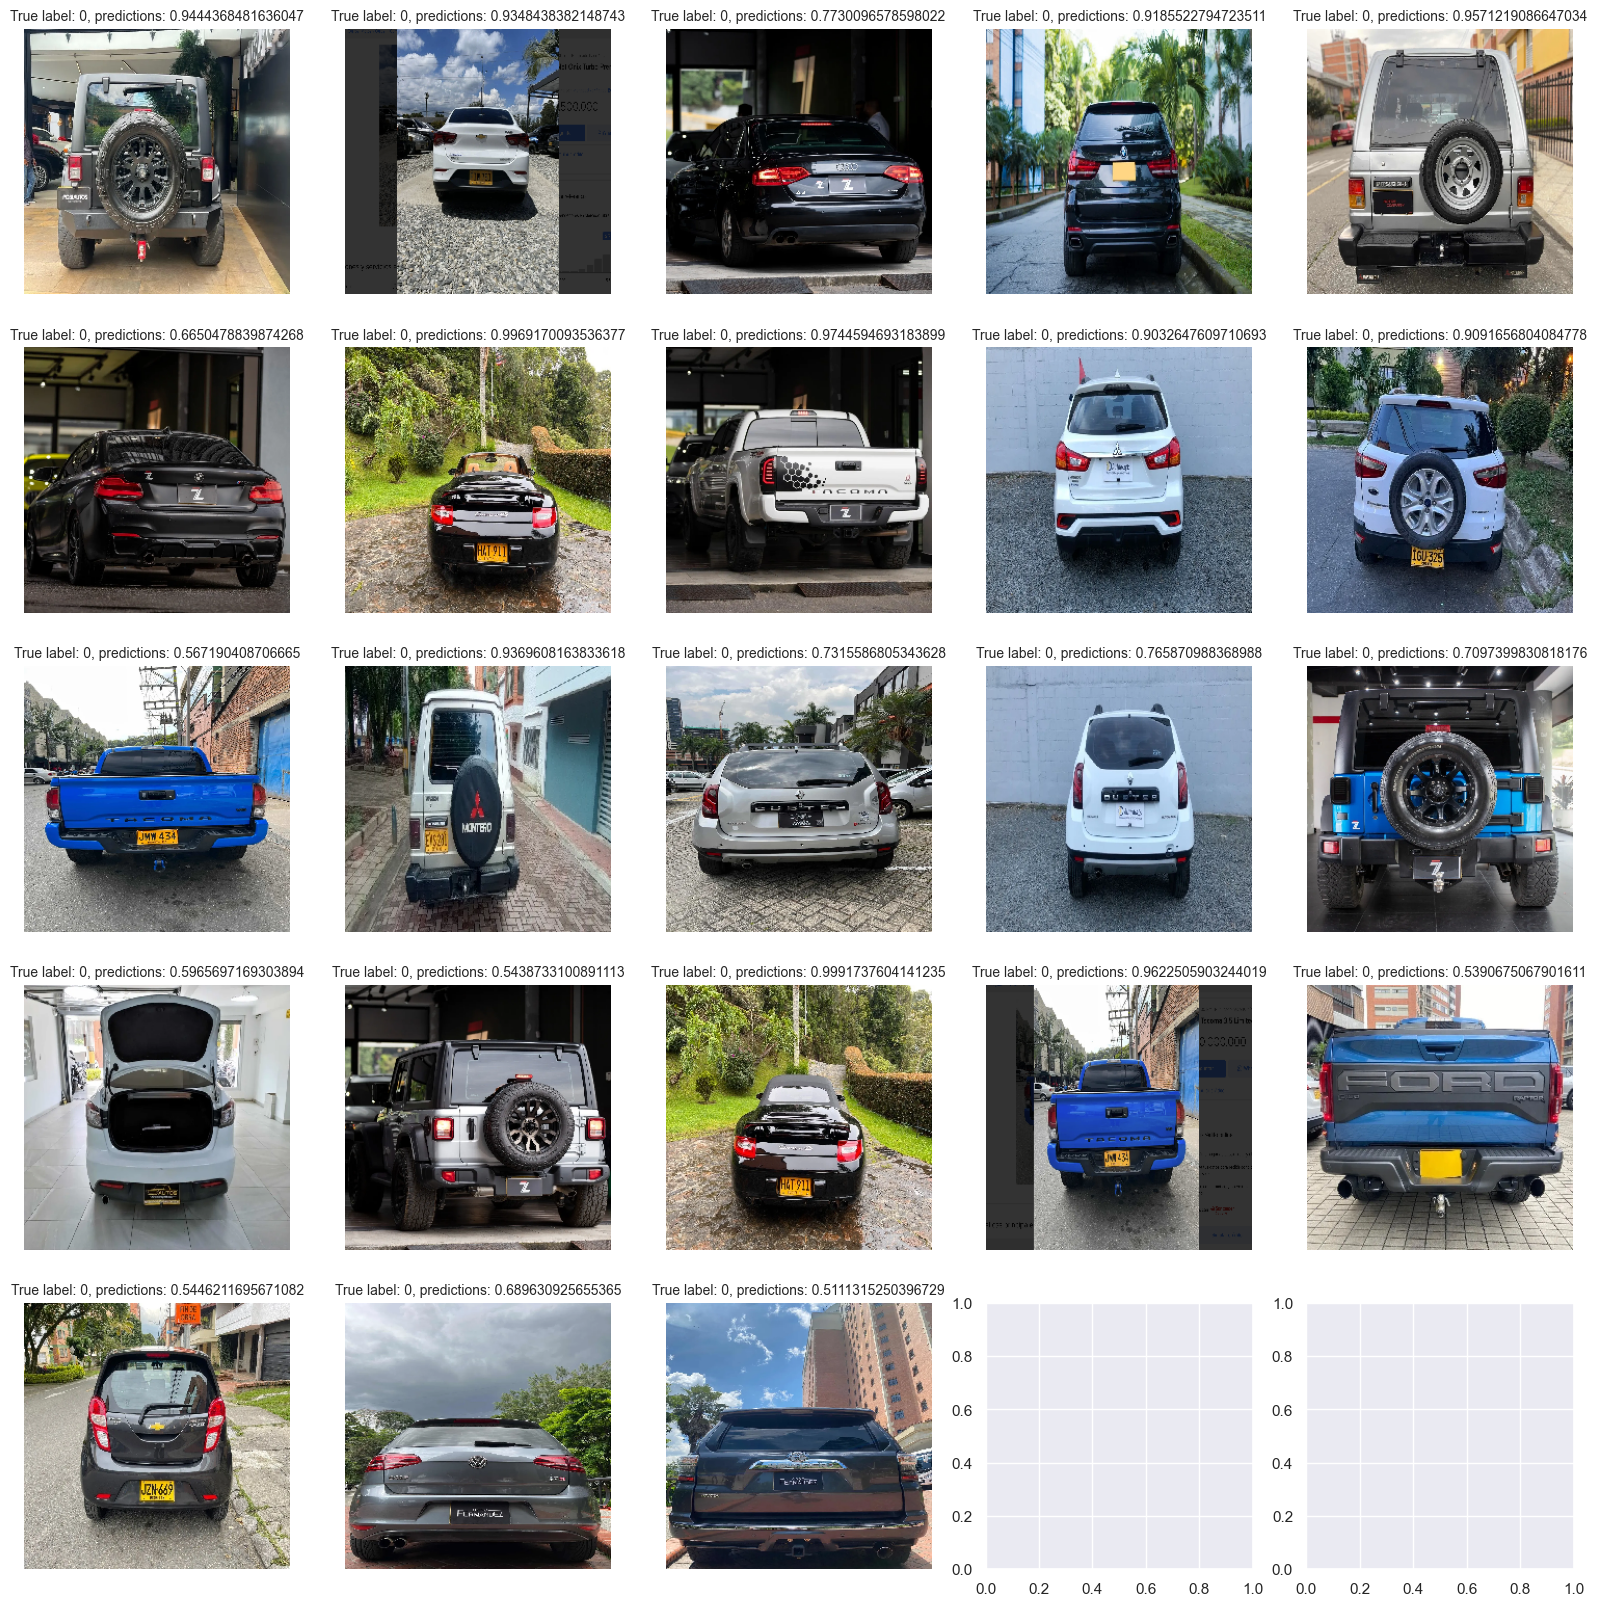

In [171]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i, ax in enumerate(fig.axes):
  try:
    error_image = tf.keras.preprocessing.image.load_img(bf_errors_1_images[i])
    ax.imshow(error_image)
    ax.axis('off')
    ax.set_title(f'True label: {bf_true_1[bf_errors_1][i]}, predictions: {bf_prediction_1[bf_errors_1][i]}', fontsize=10)
  except IndexError:
    continue
plt.show()

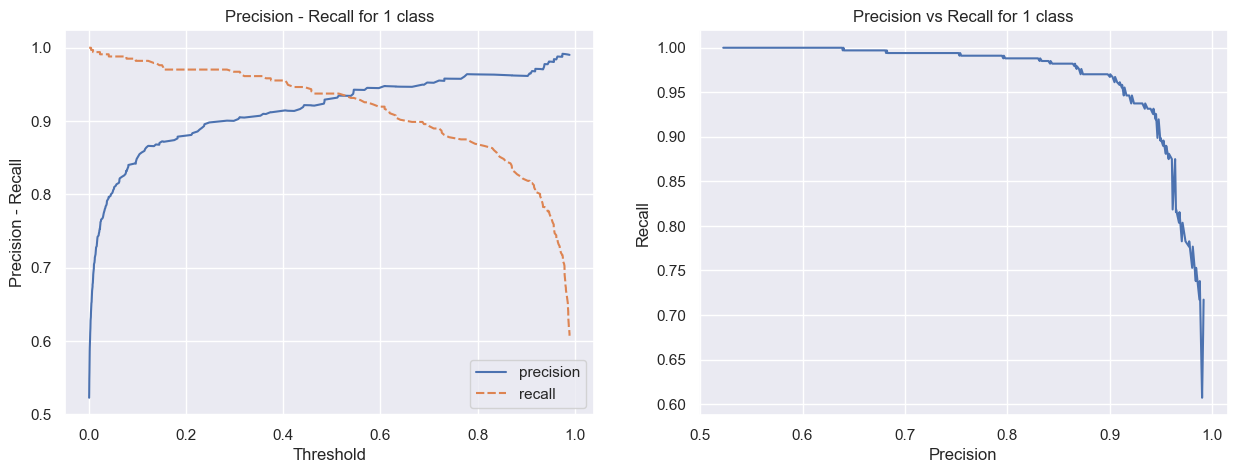

In [200]:
precision, recall, thresholds = precision_recall_curve(bf_validations_labels, bf_predictions)
prt = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1]}, index=thresholds)
prt = prt[(prt.index <= 0.99)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(data=prt, ax=ax[0])
ax[0].set_ylabel('Precision - Recall')
ax[0].set_xlabel('Threshold')
ax[0].set_title(f'Precision - Recall for 1 class')

sns.lineplot(x='precision', y='recall', data=prt, ax=ax[1])
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Precision')
ax[1].set_title(f'Precision vs Recall for 1 class')
plt.show()

In [ ]:
new_label_predictions = np.zeros(bf_predictions.shape)
thresholld = 0.95
for idx, row in enumerate(bf_predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

bf_new_cm = confusion_matrix(bf_validations_labels, new_label_predictions)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(bf_new_cm, annot=True, fmt="d", ax=ax[0])
ax[0].set_title('New Confusion Matrix')
ax[0].set_ylabel('Actual label')
ax[0].set_ylabel('predicted label')

sns.heatmap(bf_cm_old, annot=True, fmt="d", ax=ax[1])
ax[1].set_title('Old Confusion Matrix')
ax[1].set_ylabel('Actual label')
ax[1].set_ylabel('predicted label')

plt.show()

### Test Set

In [173]:
bf_test_predictions = bf_model.predict(bf_test_images)
bf_test_labels = np.array(bf_test_images.classes)

26/26 [==============================] - 3s 113ms/step


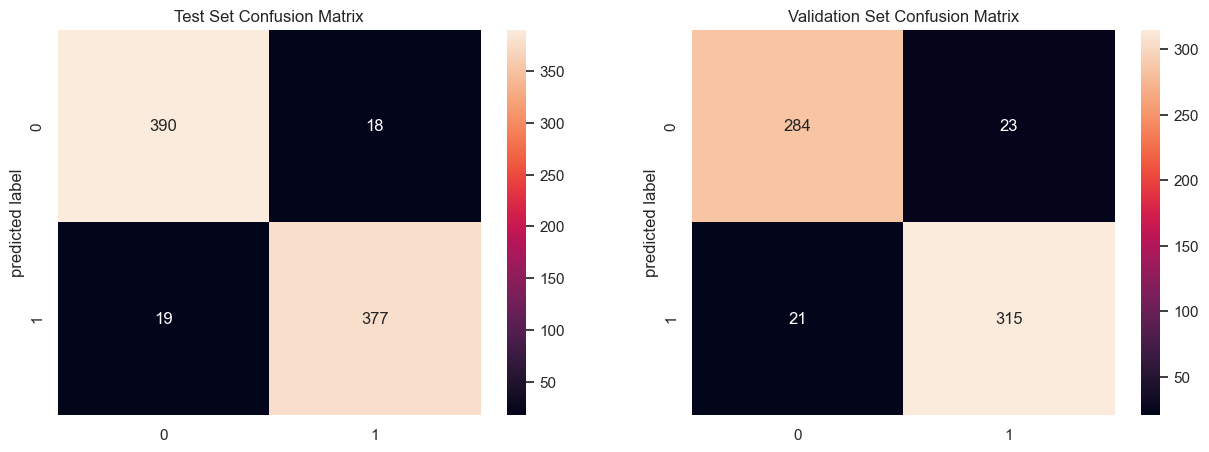

In [176]:
new_label_predictions = np.zeros(bf_test_predictions.shape)
thresholld = 0.5
for idx, row in enumerate(bf_test_predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

bf_test_cm = confusion_matrix(bf_test_labels, new_label_predictions)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(bf_test_cm, annot=True, fmt="d", ax=ax[0])
ax[0].set_title('Test Set Confusion Matrix')
ax[0].set_ylabel('Actual label')
ax[0].set_ylabel('predicted label')

sns.heatmap(bf_cm_old, annot=True, fmt="d", ax=ax[1])
ax[1].set_title('Validation Set Confusion Matrix')
ax[1].set_ylabel('Actual label')
ax[1].set_ylabel('predicted label')

plt.show()

In [177]:
bf_model.evaluate(bf_test_images)

26/26 [==============================] - 4s 101ms/step - loss: 0.1207 - accuracy: 0.9540


[0.1207399070262909, 0.9539800882339478]